In [3]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models, datasets
from torch.autograd import Variable

In [5]:
from techniques.generate_grounding import gen_grounding_gcam

In [6]:
model = models.resnet110()
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 10)
model = nn.DataParallel(model)
model_dict = torch.load('/work/lisabdunlap/explain-eval/training/checkpoint/model_best.pth.tar')
model.load_state_dict(model_dict['state_dict'])
model = model.cuda()
model.eval()
print("epoch {0} acc {1}".format(model_dict['epoch'], model_dict['acc']))

AttributeError: module 'torchvision.models' has no attribute 'resnet110'

In [ ]:
#from techniques.generate_grounding import gen_grounding

import torchvision.transforms as transforms
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=50, shuffle=True, num_workers=2)
cifar_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

In [ ]:
i = 0
correct_imgs = []
correct_labels = []
output_labels = []
correct_ind = []
correct = 0
for i, data in enumerate(testloader):
    inputs, labels = data
    inputs = Variable(inputs.float())
    labels = Variable(labels.long())  
    output = model(inputs.cuda())
    probabilities, prediction = output.topk(1, dim=1, largest=True, sorted=True)
    #print("labels: {0}".format(labels.cpu().numpy()))
    #print("predictions: {0}".format(prediction.cpu().numpy()))
    for p,l,inp in zip(prediction.cpu().numpy(), labels.cpu().numpy(), inputs):
        #print("predicted: {0}  truth: {1}".format(cifar_classes[p[0]], cifar_classes[l]))
        
        if cifar_classes[p[0]] == cifar_classes[l]:
            correct_imgs += [inp]
            correct_labels += [p[0]]
    break
print(len(correct_labels)/50)

In [11]:
import matplotlib.pyplot as plt
from Grad_CAM.old_grad_cam import old_gen_gcam
#from Grad_CAM.grad_cam import gen_gcam
from techniques.utils import get_model_info, get_displ_img
import random

car


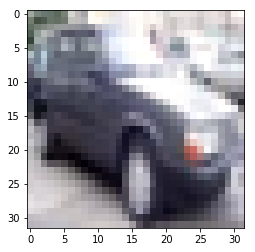

In [82]:
index = random.randint(0,len(correct_imgs)-1)
displ_img = get_displ_img(correct_imgs[index])
cv2.imwrite('test.jpg', np.uint8(displ_img*255))
plt.imshow(displ_img)
gt_label = correct_labels[index]
print(cifar_classes[gt_label])

[0.17002] amphibian
tensor(408, device='cuda:0')


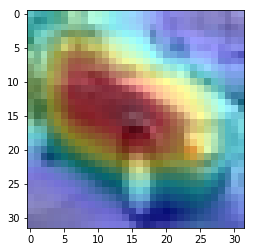

In [83]:
mask = gen_grounding_gcam(displ_img, cifar_classes[gt_label], 'resnet18', from_saved=True, show=True, save_path='./', save=False, target_index=1, layer='layer4.1')

In [62]:
epochs = []
for root, dirs, files in os.walk('/work/lisabdunlap/explain-eval/training/checkpoint', topdown=False):
    for f in files:
        if '.pth' in f and 'final' not in f:
            epoch = int(f.split('_')[-1][:-4])
            if epoch <= 250:
                epochs += [epoch]
epochs = sorted(epochs)
print(epochs)

[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 16, 18, 19, 20, 23, 34, 40, 44, 47, 49, 72, 148, 150, 151, 152, 153, 154, 155, 156, 157, 250]


[0, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 16, 18, 19, 20, 23, 34, 40, 44, 47, 49, 72, 148, 150, 151, 152, 153, 154, 155, 156, 157, 250]
epoch 0 acc 40.67
result path: /work/lisabdunlap/explain-eval/training/examples/car_0/
[1.00000] tench
tensor(0, device='cuda:0')
saving explanation mask....

saved to /work/lisabdunlap/explain-eval/training/examples/car_0/gcam-
epoch 0 acc 40.67
result path: /work/lisabdunlap/explain-eval/training/examples/car_0/
[1.00000] tench
tensor(0, device='cuda:0')
saving explanation mask....

saved to /work/lisabdunlap/explain-eval/training/examples/car_0/gcam-
epoch 1 acc 48.95
result path: /work/lisabdunlap/explain-eval/training/examples/car_1/
[0.93535] stingray
tensor(6, device='cuda:0')
saving explanation mask....

saved to /work/lisabdunlap/explain-eval/training/examples/car_1/gcam-
epoch 2 acc 55.37
result path: /work/lisabdunlap/explain-eval/training/examples/car_2/
[0.94417] tench
tensor(0, device='cuda:0')
saving explanation mask....

saved to /work/lis

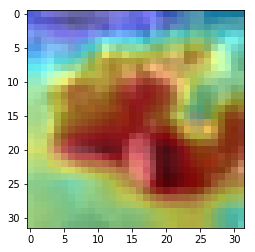

In [63]:
epochs = []
for root, dirs, files in os.walk('/work/lisabdunlap/explain-eval/training/checkpoint', topdown=False):
    for f in files:
        if '.pth' in f and 'final' not in f:
            epoch = int(f.split('_')[-1][:-4])
            if epoch <= 250:
                epochs += [epoch]
epochs = sorted(epochs)
print(epochs)

for i in epochs:
    label = 'ship_'+str(i)
    model_name='ckpt_10_'+str(i)
    
    model = models.resnet18()
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 10)
    model_dict = torch.load('/work/lisabdunlap/explain-eval/training/checkpoint/'+model_name+'.pth')
    print("epoch {0} acc {1}".format(model_dict['epoch'], model_dict['acc']))
    model.load_state_dict(model_dict['net'])
    model = model.cuda()
    model.eval()
    gcam_expl = gen_grounding_gcam(displ_img, cifar_classes[gt_label]+'_'+str(i), model, from_saved=False, show=True, save_path='/work/lisabdunlap/explain-eval/training/examples/', save=True, layer='layer4')
    #gcam_expl = gen_grounding(img, 'gcam', label, model_name, show=True, save=True, save_path='/work/lisabdunlap/explain-eval/training/examples/', index=1)
#cv2.imwrite('/work/lisabdunlap/explain-eval/training/examples/epoch0.png', img1)

In [76]:
import os
paths = {}
#for root, dirs, files in os.walk('/work/lisabdunlap/explain-eval/training/examples', topdown=False):
#    for f in files:
#        if 'ship' in root:
#            if '.png' in f and '.ipynb' not in root and 'ckpt' in f:
#                #print(os.path.join(root, f))
#                paths[int(f.split('_')[-1][:-4])] = os.path.join(root, f)

#examples are car, cat, horse, and ship
for root, dirs, files in os.walk('/work/lisabdunlap/explain-eval/training/examples', topdown=False):
    for f in files:
        if 'car' in root:
            if f == 'gcam.png':
                #print(os.path.join(root, f))
                paths[int(root.split('/')[-1].split('_')[1])] = os.path.join(root, f)
print([k for k,v in paths.items()])

[20, 18, 44, 152, 3, 4, 155, 34, 49, 148, 23, 11, 151, 47, 0, 7, 72, 40, 156, 16, 5, 154, 250, 153, 2, 8, 19, 6, 157, 150, 1, 10]


0
1
2
3
4
5
6
7
8
10
11
16
18
19
20
23
34
40
44
47
49
72
148
150
151
152
153
154
155
156
157
250


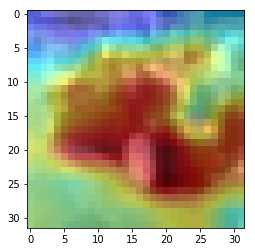

In [77]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import cv2

fig = plt.figure()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)
# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
paths_idx = sorted(paths)
for i in paths_idx:
    print(i)
    x += np.pi / 15.
    y += np.pi / 20.
    im = plt.imshow(cv2.imread(paths[i]), animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=1000, blit=True,
                                repeat_delay=1000)

HTML(ani.to_jshtml())

In [78]:
# Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
ani.save('dynamic_images.mp4', writer=writer)

ValueError: Invalid file object: <_io.BufferedReader name=99>